In [1]:
import os.path as op
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas
import time
from scipy.sparse.linalg import LinearOperator
import h5py
from scipy.sparse.linalg import eigsh
from scipy.sparse import coo_matrix
from cooltools.lib.common import make_cooler_view, align_track_with_cooler
import cooler
import cooltools
from cooltools.api.eigdecomp import _phase_eigs, eigs_cis
from cooltools.lib.numutils import _logbins_numba
from cooltools.api.expected import expected_cis
import bioframe
from multiprocessing import Pool
import multiprocessing
from cooltools.lib import numutils
from timeit import timeit
import block_decomposition as bd

In [2]:
%matplotlib inline 

In [3]:
filepath = '/users/vladimir.dmitriev/src/cooler_utils//cooler-binder/data/Rao2014-GM12878-MboI-allreps-filtered.1000kb.cool'
#filepath = '/groups/goloborodko/seqdata/hsiehDarzacq2019/mm10/distiller_0.3.3/results/coolers_library_group/ESC.mm10.mapq_30.100.mcool::/resolutions/1000'

In [4]:
c = cooler.Cooler(filepath)

In [5]:
## parameters

balance = True
block_size = 9



In [6]:
## time

t1 = timeit(lambda : bd.cys_eig_blockwise(c=c,balance=balance, ignore_diags=2, block_size=block_size), number = 1)
#t2 = timeit(lambda : eigs_cis(c, ignore_diags = 2), number = 1)

print(t1, "Blockwise time")
#print(t2, "Normal time")


/users/vladimir.dmitriev/src/cooler_utils/my_cool_utils/block_decomposition.py:426: RuntimeWarning: invalid value encountered in true_divide
  _block /= np.stack([np.concatenate((S[i:0:-1],S[:N-i])) for i in range(shift, min(shift+block_size, N))])


219.5716091760114 Blockwise time


In [9]:
%%prun
eVals_block, eVecs_block = bd.cys_eig_blockwise(c=c,balance=balance,ignore_diags=2, block_size=1000)
eVals, eVecs = eigs_cis(c, ignore_diags=2)

/users/vladimir.dmitriev/src/cooler_utils/my_cool_utils/block_decomposition.py:425: RuntimeWarning: invalid value encountered in true_divide
  _block /= np.stack([np.concatenate((S[i:0:-1],S[:N-i])) for i in range(shift, min(shift+block_size, N))])


         8603396 function calls (8288213 primitive calls) in 23.057 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2681    7.548    0.003    7.548    0.003 {method 'read' of 'h5py._selector.Reader' objects}
    14685    2.557    0.000    2.915    0.000 ffi.py:149(__call__)
      666    1.378    0.002    1.383    0.002 files.py:200(make_fid)
      533    0.968    0.002    9.312    0.017 core.py:253(query)
     6560    0.694    0.000    1.002    0.000 group.py:296(__getitem__)
165991/158387    0.571    0.000    0.998    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        4    0.440    0.110    0.440    0.110 {pandas._libs.join.left_outer_join}
      666    0.360    0.001    0.361    0.001 files.py:516(close)
  1435163    0.268    0.000    0.362    0.000 {built-in method builtins.isinstance}
      483    0.168    0.000   11.336    0.023 block_decomposition.py:355(BlockMult)
157255/28148 

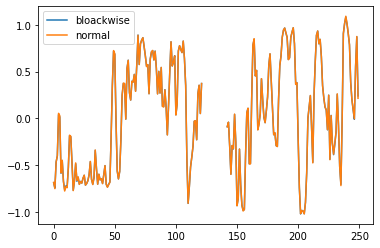

In [10]:
e1 = eVecs_block[eVecs_block['chrom'] == 'chr1']['E1']
e2 = eVecs[eVecs['chrom'] == 'chr1']['E1']

if np.max(np.abs(e1+e2)) < np.max(np.abs(e1-e2)):
    e1 =-e1

plt.plot(e1, label="bloackwise")
plt.plot(e2, label="normal")
plt.legend()
plt.show()

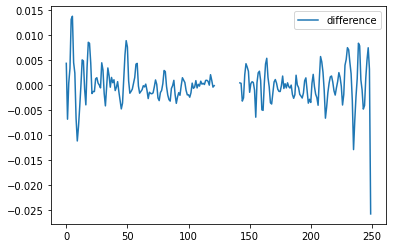

In [11]:
plt.plot(e2-e1, label="difference")
plt.legend()
plt.show()